In [1]:
import os
import shutil
import numpy as np
import gc
import pandas as pd
import catboost as cb
from catboost import Pool
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import re
from sklearn.metrics import roc_auc_score

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.DataFrame.iteritems = pd.DataFrame.items
warnings.simplefilter('ignore')

PATH = '../input/'

DEBUG = True
DEBUG = False

if DEBUG: 
    n_rows = 50000
else: 
    n_rows = None

In [2]:
train_views = pl.read_parquet(
    PATH + 'train_views.parquet',
    n_rows = n_rows
)
print(train_views.shape)
train_views.head(3)

(1502904, 60)


bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status
str,str,str,str,str,str,str,str,str,str,str,i32,str,f64,str,str,str,str,f64,bool,bool,bool,str,str,str,i32,i32,f64,i32,f64,str,i32,f64,str,i32,i32,f64,str,str,str,str,str,str,str,str,f64,str,i32,str,str,str,str,str,str,bool,str,str,i32,i32,i32
"""https://hd.23l…","""https://hd.23l…","""7f7cae3961b13a…","""Subnet LLC""","""https://incant…",null,"""5friJXI0gxS""","""ohmybid""","""6ae23bce1c8c4e…","""87""","""728x90""",1,null,0.0001,"""UNKNOWN""","""subnet llc""",null,null,0.0,true,false,false,"""iab24""",null,"""72,73""",2,-2,null,-1,null,"""ohmybid_87_ukS…",4,0.0,null,11527,657906,180.0,null,null,null,null,"""2024-01-05 10:…","""5""","""Makhachkala""","""367000""",0.0,null,0,null,null,null,"""DESKTOP""","""WINDOWS""","""YANDEX""",true,"""10""","""23.11.0.0""",0,1,11
"""https://hd.8lo…","""https://hd.8lo…","""5088e30457fb86…","""ER-Telecom""","""https://incant…",null,"""xegyvF0fCt7""","""buzzoola""","""1217284""","""15747""","""300x250""",1,null,11.0,"""ABOVE""","""er-telecom""","""K""",null,0.0,true,false,false,"""iab1-5""",null,"""72,73""",2,-2,80.0,-1,null,"""buzzoola_15747…",4,null,null,11527,657909,420.0,null,null,null,null,"""2024-01-06 17:…","""24""","""Krasnoyarsk""","""660000""",0.0,null,0,null,null,null,"""SMARTPHONE""","""ANDROID""","""CHROME""",true,"""10""","""120.0.0.0""",0,1,11
"""https://schast…",null,"""3d563122099bde…","""Beeline Home""","""https://www.mv…","""ru""","""QYMZhsIbgI""","""ohmybid""","""a8ac3391dabe31…","""90""","""300x250""",1,null,24.36,"""UNKNOWN""","""beeline home""",null,null,0.0,true,false,false,"""iab24""",null,"""72""",2,-2,null,-1,null,"""ohmybid_90_643…",2,0.0,null,12453,651855,180.0,null,null,null,"""2094,42890,447…","""2024-01-22 21:…","""77""","""Moskva""","""104015""",0.0,"""giJHLtcB3Oq""",3,null,null,null,"""DESKTOP""","""WINDOWS""","""CHROME""",true,"""10""","""109.0.0.0""",0,1,1


In [3]:
train_actions = pl.read_parquet(
    PATH + 'train_actions.parquet',
    n_rows = None
)
print(train_actions.shape)
train_actions.head()

(644856, 6)


time,ssp_event_id,clicks,conversion_name,is_post_click,is_post_view
str,str,i32,str,i64,i64
"""2024-01-02 21:…","""uxxLGVvM1aOs""",0,"""pereyti""",1,0
"""2024-01-02 21:…","""M9no149TZAc""",0,"""pereyti""",1,0
"""2024-01-02 21:…","""xY4srE5hee8""",0,"""pereyti""",1,0
"""2024-01-02 21:…","""0gcd7iQx2H9""",0,"""pereyti""",1,0
"""2024-01-02 21:…","""s0snGGmhlNa""",0,"""pereyti""",1,0


In [4]:
train_action = (
    train_actions
    .filter((pl.col('conversion_name') == 'cart') & (pl.col('is_post_click') == 1))
    [['ssp_event_id', 'is_post_click']]
)

print(train_action.shape)
train_action.head()

(277, 2)


ssp_event_id,is_post_click
str,i64
"""uP5l2jtPdMbQ""",1
"""8D27VOWGBxb""",1
"""u6RTW1rb0TAJ""",1
"""u6RTW1rb0TAJ""",1
"""u6RTW1rb0TAJ""",1


In [5]:
df = train_views.join(train_action, how = 'left', on = 'ssp_event_id')
df.head()

bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,is_post_click
str,str,str,str,str,str,str,str,str,str,str,i32,str,f64,str,str,str,str,f64,bool,bool,bool,str,str,str,i32,i32,f64,i32,f64,str,i32,f64,str,i32,i32,f64,str,str,str,str,str,str,str,str,f64,str,i32,str,str,str,str,str,str,bool,str,str,i32,i32,i32,i64
"""https://hd.23l…","""https://hd.23l…","""7f7cae3961b13a…","""Subnet LLC""","""https://incant…",null,"""5friJXI0gxS""","""ohmybid""","""6ae23bce1c8c4e…","""87""","""728x90""",1,null,0.0001,"""UNKNOWN""","""subnet llc""",null,null,0.0,true,false,false,"""iab24""",null,"""72,73""",2,-2,null,-1,null,"""ohmybid_87_ukS…",4,0.0,null,11527,657906,180.0,null,null,null,null,"""2024-01-05 10:…","""5""","""Makhachkala""","""367000""",0.0,null,0,null,null,null,"""DESKTOP""","""WINDOWS""","""YANDEX""",true,"""10""","""23.11.0.0""",0,1,11,null
"""https://hd.8lo…","""https://hd.8lo…","""5088e30457fb86…","""ER-Telecom""","""https://incant…",null,"""xegyvF0fCt7""","""buzzoola""","""1217284""","""15747""","""300x250""",1,null,11.0,"""ABOVE""","""er-telecom""","""K""",null,0.0,true,false,false,"""iab1-5""",null,"""72,73""",2,-2,80.0,-1,null,"""buzzoola_15747…",4,null,null,11527,657909,420.0,null,null,null,null,"""2024-01-06 17:…","""24""","""Krasnoyarsk""","""660000""",0.0,null,0,null,null,null,"""SMARTPHONE""","""ANDROID""","""CHROME""",true,"""10""","""120.0.0.0""",0,1,11,null
"""https://schast…",null,"""3d563122099bde…","""Beeline Home""","""https://www.mv…","""ru""","""QYMZhsIbgI""","""ohmybid""","""a8ac3391dabe31…","""90""","""300x250""",1,null,24.36,"""UNKNOWN""","""beeline home""",null,null,0.0,true,false,false,"""iab24""",null,"""72""",2,-2,null,-1,null,"""ohmybid_90_643…",2,0.0,null,12453,651855,180.0,null,null,null,"""2094,42890,447…","""2024-01-22 21:…","""77""","""Moskva""","""104015""",0.0,"""giJHLtcB3Oq""",3,null,null,null,"""DESKTOP""","""WINDOWS""","""CHROME""",true,"""10""","""109.0.0.0""",0,1,1,null
"""https://drive2…",null,"""c3d678eab044b8…","""Shark Telecom …","""https://www.mv…","""ru""","""5icvt0bMxNT""","""ohmybid""","""a11f3ad5b41c12…","""88""","""300x600""",1,null,19.082,"""UNKNOWN""","""shark telecom …","""Desktop""",null,0.0,true,false,false,"""iab2""",null,"""72""",2,-2,null,0,0.0,"""ohmybid_88_592…",2,0.0,null,12453,651856,180.0,null,null,null,"""44655,44820,16…","""2024-01-20 10:…","""77""","""Moskva""","""104015""",0.0,"""uxWV5Ar8m4xR""",3,null,null,null,"""DESKTOP""","""WINDOWS""","""OPERA""",true,"""10""","""106.0.0.0""",0,1,1,null
"""https://3-hd.l…","""https://3-hd.l…","""e31e1c1211aae1…","""Moscow City Te…","""https://www.mv…","""ru""","""5QcQe2TFB3y""","""skyadvert""",null,"""1095""","""300x250""",1,null,15.0,"""ABOVE""","""moscow city te…",null,null,0.0,true,false,false,"""iab1-5""",null,"""72,73""",0,-2,null,-1,null,"""skyadvert_1095…",2,null,null,12453,651855,180.0,null,null,null,"""48085,44655,44…","""2024-01-15 17:…","""77""","""Moskva""","""104015""",0.0,"""7tj3G3l2FDm""",3,null,null,null,"""SMARTPHONE""","""ANDROID""","""CHROME""",true,"""10""","""120.0.0.0""",0,3,1,null


In [6]:
df = df.with_columns(
    pl.col('is_post_click').fill_null(0)
)

In [7]:
df = df.drop('ssp_event_id')

In [8]:
# rename target column
df = df.rename({'is_post_click': 'label'})

In [9]:
df = df.to_pandas()

In [10]:
print(df.shape)
df = df[df['user_id'] == df['user_id']]
print(df.shape)

(1503055, 60)
(1006422, 60)


In [11]:
check_file = os.path.exists('val.parquet')

if check_file:
    pass
else:
    temp = df.sample(frac = 0.1)
    temp.to_parquet('val.parquet')

In [12]:
import os

os.makedirs('models', exist_ok = True)

In [13]:
%%writefile './models/data_features.py'
import pandas as pd
import re
import numpy as np

def data_processor(df: pd.DataFrame, is_test = False) -> pd.DataFrame:
    
    df['time'] = pd.to_datetime(df['time'])    
    ##df['number_weekday'] = df['time'].dt.weekday
    ##df['number_day'] = df['time'].dt.day    
    df['number_hour'] = df['time'].dt.hour    
    
        
    df['landing_page'] = df['landing_page'].apply(lambda x: x.replace(' ', ''))
    df['landing_page'] = df['landing_page'].apply(lambda x: x.replace('   ', ''))  
    df['landing_page'] = df['landing_page'].apply(lambda x: x.replace(u'\xa0', u'')) 
    df['landing_page'] = df['landing_page'].apply(lambda x: x.replace(u'\x20', u''))
    df['landing_page'] = df['landing_page'].apply(lambda x: x.replace(u'32', u''))
    df['landing_page'] = df['landing_page'].apply(lambda x: "".join(x.split()))
    
    df['landing_catalog'] = df['landing_page'].apply(lambda x: re.sub('utm_term=.*','', x, flags = re.DOTALL))
    
    df['creative_size_height'] = df['creative_size'].apply(lambda x: int(x.split('x')[0]))
    df['creative_size_width'] = df['creative_size'].apply(lambda x:  int(x.split('x')[1]))
    
    df['full_placement_id2'] = df['full_placement_id'].apply(lambda x: x.split('_')[0])

    df['device_screen'] = df['device_screen'].fillna('-1')
    
    df['host'] = df['landing_page'].apply(lambda x:  x.split('/')[2])
 
    df[f'battr'] = df[f'battr'].fillna('-1')
    for i in [-1, 1, 2, 5, 6, 7, 15, 16]:
        df[f'battr_{i}'] = df['battr'].apply(lambda x: i if str(i) in x.split(',') else 0)        

    
    ####
    for u in ['39804', '7802', '7952', '7974', '44874', '8035']:
        df.loc[df['user_segments'] == df['user_segments'], f'user_segments_{u}'] = (
            df.loc[df['user_segments'] == df['user_segments'], 'user_segments']
            .apply(lambda x: 1 if u in x else 0)
        )
    ####    
    
    df.drop(['landing_page', 'battr', 'carrier_id'], axis = 1, inplace = True)
    cat_features = list(df.columns[df.dtypes == 'object'])
    num_features = list(df.columns[~(df.dtypes == 'object')])

    cat_features = [f for f in cat_features if f not in ['label', 'time']]
    num_features = [f for f in num_features if f not in ['label', 'time']]
    
   
    for col in cat_features:
        try:
            m = df[col].mode()[0]
            df[col] = df[col].fillna(m)
        except:
            df[col] = df[col].fillna('-999')
                
            
    for col in num_features:
        try:
            m = df[col].mean()
            df[col] = df[col].fillna(m) 
        except:
            df[col] = df[col].fillna(-999)
            
    #remove = ['user_fraud_state', 'user_id', 'full_placement_id', 'visibility', ' advertiser_id']
    #for u in remove:
    #    if u in cat_features:
    #        cat_features.remove(u)
    #    if u in num_features:
    #        num_features.remove(u)

    df[cat_features] = df[cat_features].astype(str)
    return df, cat_features, num_features

Writing ./models/data_features.py


In [15]:
from models.data_features import data_processor

df.reset_index(drop = True, inplace = True)
df_temp = df.copy()
df_temp, cat_features, num_features = data_processor(df_temp)
use = cat_features + num_features

In [16]:
print(df_temp[use].shape)
df_temp[use].drop_duplicates(inplace = True)
print(df_temp[use].shape)

(1006422, 75)
(1006422, 75)


In [17]:
print(df.shape)
df = df[df.index.isin(df_temp.index)]
df.reset_index(drop = True, inplace = True)
print(df.shape)

(1006422, 60)
(1006422, 60)


In [18]:
np.array(cat_features)

array(['bid_url', 'bid_referer', 'bid_ip', 'bid_isp_name',
       'page_language', 'ssp', 'tag_id', 'publisher_id', 'creative_size',
       'visibility', 'model', 'mobile_screen_size', 'content_category',
       'mime_types', 'content_tags', 'full_placement_id', 'device_screen',
       'utm_source', 'search_engine', 'search_terms', 'user_segments',
       'region_code', 'city', 'zip_code', 'user_id', 'ud_cookie_ts',
       'accept_encoding', 'accept_language', 'ua_device_type', 'ua_os',
       'ua_browser', 'ua_os_version', 'ua_browser_version',
       'landing_catalog', 'full_placement_id2', 'host'], dtype='<U18')

In [19]:
np.array(num_features)

array(['creative_type', 'floor_cpm', 'screen_pixel_ratio', 'is_https',
       'ibv_blocked', 'is_interstitial', 'iframe_state',
       'ads_txt_support', 'historical_viewability', 'gdpr_regulation',
       'do_not_track', 'user_fraud_state', 'is_mobile_optimized_site',
       'advertiser_id', 'creative_id', 'timezone_offset', 'isp_type',
       'user_detection_type', 'ua_third_party_cookie', 'ua_parsing_type',
       'ua_type', 'user_status', 'number_hour', 'creative_size_height',
       'creative_size_width', 'battr_-1', 'battr_1', 'battr_2', 'battr_5',
       'battr_6', 'battr_7', 'battr_15', 'battr_16',
       'user_segments_39804', 'user_segments_7802', 'user_segments_7952',
       'user_segments_7974', 'user_segments_44874', 'user_segments_8035'],
      dtype='<U24')

In [20]:
df['label'].value_counts()

label
0    1006164
1        258
Name: count, dtype: int64

In [21]:
df[df['label'] == 0].shape[0] / df[df['label'] == 1].shape[0]

3899.860465116279

In [22]:
df.time.sort_values()

121492    2024-01-02 21:00:03
156861    2024-01-02 21:00:03
439393    2024-01-02 21:00:04
278951    2024-01-02 21:00:05
827709    2024-01-02 21:00:05
                 ...         
444582    2024-01-23 23:59:54
67586     2024-01-23 23:59:55
507749    2024-01-23 23:59:55
199063    2024-01-23 23:59:56
238820    2024-01-23 23:59:57
Name: time, Length: 1006422, dtype: object

In [23]:
def plot_feature_importance(importance, names, model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending = False, inplace = True)
    #Define size of bar plot
    plt.figure(figsize = (10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y = fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [31]:
tokenizers = [
    {
        'tokenizer_id': 'Sense',
        'separator_type': 'BySense',
        'lowercasing': 'True',
        'token_types':['Word', 'Number', 'SentenceBreak'],
        'sub_tokens_policy':'SeveralTokens'
    }      
]
dictionaries = [
    {
        'dictionary_id': 'Word',
        'max_dictionary_size': '50000'
    }
]
feature_calcers = [
    'BoW:top_tokens_count=10000'
]

In [34]:
def get_score(verbose = 100, remove = False):

    SEEDS = 1
    models = []
    score = []

    for seed in range(SEEDS):
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed) 
        for train_index, valid_index in skf.split(df, df['label']):    
            X_train, X_test = df.iloc[train_index], df.iloc[valid_index]
            y_train, y_test = df['label'].iloc[train_index], df['label'].iloc[valid_index]
            X_train.reset_index(drop = True, inplace = True)
            X_test.reset_index(drop = True, inplace = True)    

            X_train, cat_features, num_features = data_processor(X_train)
            X_test, _, _  = data_processor(X_test)
            use = cat_features + num_features              
                
            ####
            if remove:
                for u in remove:
                    if u in cat_features:
                        cat_features.remove(u)
                    if u in num_features:
                        num_features.remove(u)
                use = cat_features + num_features
            ####


            model = cb.CatBoostClassifier(                
                learning_rate = 0.03,            
                #depth = 3,
                #l2_leaf_reg = 0.001,
            
                iterations = 2500, 
                scale_pos_weight = 4,
                #cat_features = cat_features2,
                loss_function = 'Logloss',
                eval_metric = "AUC",
                early_stopping_rounds = 100,
                verbose = verbose,
                random_state = seed,
                task_type = 'GPU',
                metric_period = 1,
                #max_ctr_complexity = 1,
                use_best_model = True,
                #one_hot_max_size = 255
                tokenizers = tokenizers, 
                dictionaries = dictionaries,
                feature_calcers = feature_calcers
            )
            
            train = Pool(
                X_train[use], 
                y_train,
                cat_features = cat_features,
                text_features = ['search_terms']
            )
            val = Pool(
                X_test[use], 
                y_test,
                cat_features = cat_features,
                text_features = ['search_terms']
            )            
            model.fit(train, eval_set = val)
            models.append(model)

            predictions = model.predict_proba(X_test[use])[:, 1]
            sc = roc_auc_score(y_test, predictions)
            score.append(sc)
        
    if verbose:
        print('\n', np.std(score))
    return np.mean(score) - np.std(score), models, use, cat_features, num_features

In [35]:
best, models, use, cat_features, num_features = get_score()

joblib.dump(models, './models/models.pkl', compress = 7)
joblib.dump([use, cat_features, num_features], './models/use.pkl')
print(best)

0:	test: 0.5449443	best: 0.5449443 (0)	total: 171ms	remaining: 7m 6s
100:	test: 0.9748374	best: 0.9748374 (100)	total: 17.9s	remaining: 7m 5s
200:	test: 0.9733285	best: 0.9748374 (100)	total: 35.2s	remaining: 6m 42s
bestTest = 0.9748373628
bestIteration = 100
Shrink model to first 101 iterations.
0:	test: 0.5536285	best: 0.5536285 (0)	total: 162ms	remaining: 6m 43s
100:	test: 0.9775220	best: 0.9775653 (88)	total: 17s	remaining: 6m 42s
200:	test: 0.9754239	best: 0.9779344 (148)	total: 34.4s	remaining: 6m 33s
bestTest = 0.9779343605
bestIteration = 148
Shrink model to first 149 iterations.
0:	test: 0.6259995	best: 0.6259995 (0)	total: 203ms	remaining: 8m 28s
100:	test: 0.9509625	best: 0.9512556 (61)	total: 17.9s	remaining: 7m 4s
200:	test: 0.9517974	best: 0.9521237 (197)	total: 35s	remaining: 6m 39s
bestTest = 0.9521236718
bestIteration = 197
Shrink model to first 198 iterations.
0:	test: 0.6444256	best: 0.6444256 (0)	total: 173ms	remaining: 7m 13s
100:	test: 0.9338751	best: 0.9342904 (7

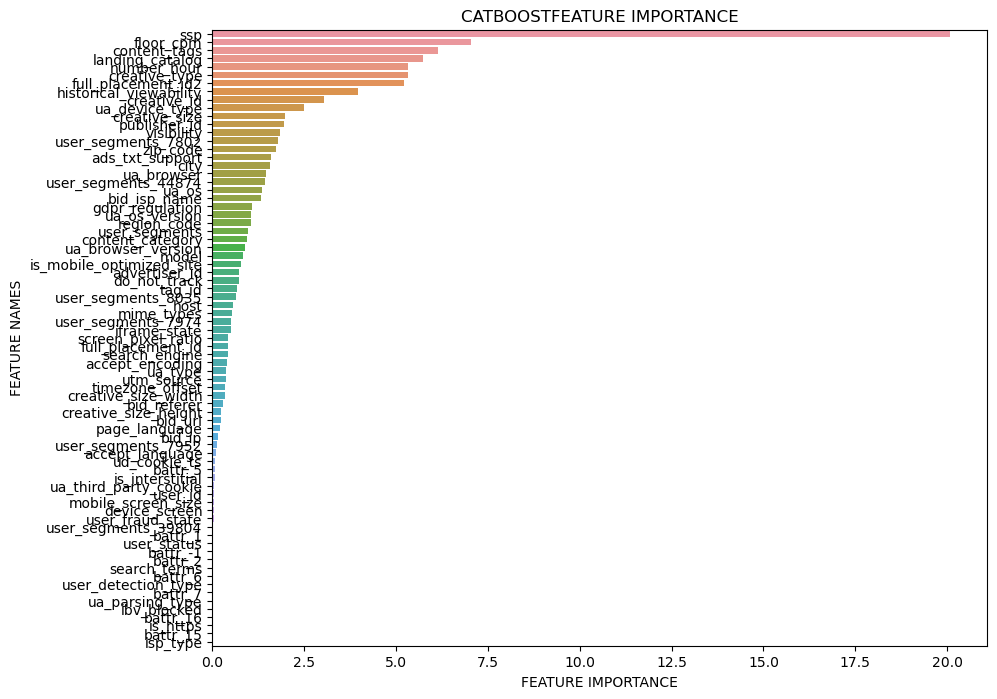

In [36]:
feature_importance = 0

for model in models:
    feature_importance += np.array(model.get_feature_importance())
feature_importance = feature_importance / len(models)

plot_feature_importance(feature_importance, use, 'CATBOOST')

In [37]:
feature_importance = 0

for model in models:
    feature_importance += np.array(model.get_feature_importance())
feature_importance = feature_importance / len(models)

feature_names = np.array(use)
#Create a DataFrame using a Dictionary
data = {'feature_names':feature_names, 'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
(
    fi_df
    .sort_values(by = ['feature_importance'], ascending = True, inplace = True)    
)
fi_df = fi_df.reset_index(drop = True)

fi_df['type'] = ''
fi_df.loc[fi_df['feature_names'].isin(cat_features), 'type'] = 'cat'
fi_df.loc[fi_df['feature_names'].isin(num_features), 'type'] = 'num'
fi_df

,feature_names,feature_importance,type
0,isp_type,0.000000,num
1,battr_15,0.000000,num
2,is_https,0.000003,num
3,battr_16,0.001451,num
4,ibv_blocked,0.001831,num
5,ua_parsing_type,0.002038,num
6,battr_7,0.002040,num
7,user_detection_type,0.003111,num
8,battr_6,0.003732,num
9,search_terms,0.004253,cat


In [38]:
feature = fi_df['feature_names'].to_list()
np.array(feature)

array(['isp_type', 'battr_15', 'is_https', 'battr_16', 'ibv_blocked',
       'ua_parsing_type', 'battr_7', 'user_detection_type', 'battr_6',
       'search_terms', 'battr_2', 'battr_-1', 'user_status', 'battr_1',
       'user_segments_39804', 'user_fraud_state', 'device_screen',
       'mobile_screen_size', 'user_id', 'ua_third_party_cookie',
       'is_interstitial', 'battr_5', 'ud_cookie_ts', 'accept_language',
       'user_segments_7952', 'bid_ip', 'page_language', 'bid_url',
       'creative_size_height', 'bid_referer', 'creative_size_width',
       'timezone_offset', 'utm_source', 'ua_type', 'accept_encoding',
       'search_engine', 'full_placement_id', 'screen_pixel_ratio',
       'iframe_state', 'user_segments_7974', 'mime_types', 'host',
       'user_segments_8035', 'tag_id', 'do_not_track', 'advertiser_id',
       'is_mobile_optimized_site', 'model', 'ua_browser_version',
       'content_category', 'user_segments', 'region_code',
       'ua_os_version', 'gdpr_regulation', 'bi

https://codenrock.com/contests/gpm-adtech-challenge#/